# COVID-19 X-ray Classification with PyTorch

This notebook contains the complete training pipeline for COVID-19 detection using chest X-ray images from the COVID-Xray-5k dataset.

## Features:
- **Metal Performance Shaders (MPS)** support for Apple Silicon
- **Complete training pipeline** with validation and testing
- **Real-time visualization** of training progress
- **Comprehensive evaluation** with detailed metrics
- **Model saving and loading** functionality

## 1. Import Libraries and Setup

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from PIL import Image
import os
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0
CUDA available: False
MPS available: True


## Download COVID-Xray-5k Dataset

Use this cell to automatically download and extract the dataset into the `data_upload_v3/` folder. If it already exists, the cell will skip downloading and print the structure.


In [2]:
# Download the COVID-Xray-5k dataset from Dropbox
import urllib.request
import zipfile
import shutil
import os


def download_dataset():
    """Download and extract the COVID-Xray-5k dataset"""

    # Dataset URL (Dropbox link)
    dataset_url = "https://www.dropbox.com/scl/fi/ajy4i9u4bjt4ho3dz4l37/data_upload_v3.zip?rlkey=kyh5oz91vykk7cao6jiip4dyn&e=1&dl=1"
    zip_filename = "covid_xray_5k.zip"
    extract_dir = "data_upload_v3"

    # Check if dataset already exists
    if os.path.exists(extract_dir):
        print(f"Dataset already exists at: {extract_dir}")
        print(f"Contents: {os.listdir(extract_dir)}")
        return True

    print("Downloading COVID-Xray-5k dataset...")
    print(f"URL: {dataset_url}")
    print(f"Saving to: {zip_filename}")

    try:
        # Download the dataset
        urllib.request.urlretrieve(dataset_url, zip_filename)
        print(f"Download completed: {zip_filename}")

        # Get file size
        file_size = os.path.getsize(zip_filename) / (1024 * 1024)  # MB
        print(f"File size: {file_size:.2f} MB")

        # Extract the dataset
        print(f"Extracting to: {extract_dir}")
        with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
            zip_ref.extractall(".")

        print(f"Extraction completed!")

        # Clean up zip file
        os.remove(zip_filename)
        print(f"Cleaned  Cleaned up: {zip_filename}")

        # Verify dataset structure
        if os.path.exists(extract_dir):
            print(f"\nFolder Dataset structure:")
            for item in os.listdir(extract_dir):
                item_path = os.path.join(extract_dir, item)
                if os.path.isdir(item_path):
                    subdirs = os.listdir(item_path)
                    print(f"  Subfolder {item}/: {subdirs}")
                    for subdir in subdirs:
                        subdir_path = os.path.join(item_path, subdir)
                        if os.path.isdir(subdir_path):
                            file_count = len([f for f in os.listdir(subdir_path)
                                               if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))])
                            print(f"    Folder {subdir}/: {file_count} images")

        print(f"\nSuccess Dataset ready for training!")
        return True

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print(f"Please check your internet connection and try again")
        return False


# Download the dataset
dataset_ready = download_dataset()

if not dataset_ready:
    print("\nWarning  Dataset download failed. Please check the error above.")
    print("You can manually download the dataset from:")
    print("https://www.dropbox.com/scl/fi/ajy4i9u4bjt4ho3dz4l37/data_upload_v3.zip?rlkey=kyh5oz91vykk7cao6jiip4dyn&e=1&dl=0")
    print("And extract it to 'data_upload_v3' directory.")


URL: https://www.dropbox.com/scl/fi/ajy4i9u4bjt4ho3dz4l37/data_upload_v3.zip?rlkey=kyh5oz91vykk7cao6jiip4dyn&e=1&dl=1
Saving to: covid_xray_5k.zip
Download completed: covid_xray_5k.zip
File size: 350.79 MB
Extracting to: data_upload_v3
Extraction completed!
Cleaned  Cleaned up: covid_xray_5k.zip

Folder Dataset structure:
  Subfolder test/: ['non', 'covid']
    Folder non/: 0 images
    Folder covid/: 100 images
  Subfolder train/: ['non', 'covid']
    Folder non/: 2000 images
    Folder covid/: 84 images

Success Dataset ready for training!


## 2. Device Configuration (Apple Silicon Optimized)

In [3]:
def get_device():
    """Get the best available device with Metal support for Apple Silicon"""
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using Metal Performance Shaders (MPS) on Apple Silicon")
        return device
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA GPU")
        return device
    else:
        device = torch.device("cpu")
        print("Using CPU (Metal/CUDA not available)")
        return device

# Get the device
device = get_device()
print(f"Selected device: {device}")

Using Metal Performance Shaders (MPS) on Apple Silicon
Selected device: mps


## 3. Dataset Class for COVID-Xray-5k

In [4]:
class COVIDXray5kDataset(Dataset):
    """Dataset class for COVID-Xray-5k dataset with proper train/test split"""
    
    def __init__(self, data_dir, split='train', transform=None, target_size=(224, 224)):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.target_size = target_size
        
        # Define paths
        self.covid_path = os.path.join(data_dir, split, 'covid')
        self.non_covid_path = os.path.join(data_dir, split, 'non')
        
        # Get file lists (recursively to handle deeper folder structures)
        self.covid_files = self._get_image_files(self.covid_path)
        self.non_covid_files = self._get_image_files(self.non_covid_path)
        
        # Create labels: 0 for non-COVID, 1 for COVID
        self.files = self.non_covid_files + self.covid_files
        self.labels = [0] * len(self.non_covid_files) + [1] * len(self.covid_files)
        
        # Shuffle only for training split to avoid data leakage concerns in eval
        if self.split == 'train':
            indices = np.arange(len(self.files))
            np.random.shuffle(indices)
            self.files = [self.files[i] for i in indices]
            self.labels = [self.labels[i] for i in indices]
        
        print(f"{split.capitalize()} dataset loaded:")
        print(f"  COVID-19: {len(self.covid_files)} images")
        print(f"  Non-COVID: {len(self.non_covid_files)} images")
        print(f"  Total: {len(self.files)} images")
    
    def _get_image_files(self, directory):
        """Recursively collect image files from a directory and all subdirectories"""
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
        files = []
        if not os.path.exists(directory):
            print(f"Warning  Directory not found: {directory}")
            return files
        for root, _, filenames in os.walk(directory):
            for filename in filenames:
                if any(filename.lower().endswith(ext) for ext in image_extensions):
                    files.append(os.path.join(root, filename))
        return files
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        
        # Load and preprocess image
        try:
            image = Image.open(img_path).convert('L')  # Convert to grayscale
            
            if self.transform:
                image = self.transform(image)
            
            return image, label
            
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image if loading fails
            dummy_img = Image.new('L', self.target_size, 128)
            if self.transform:
                dummy_img = self.transform(dummy_img)
            return dummy_img, label

print("COVIDXray5kDataset class defined!")

COVIDXray5kDataset class defined!


## 4. CNN Model Architecture (ResNet18-based)

In [5]:
class COVID19Classifier(nn.Module):
    """CNN-based classifier for COVID-19 detection optimized for Apple Silicon"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(COVID19Classifier, self).__init__()
        
        # Use ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=pretrained)
        
        # Modify first layer to accept grayscale images
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify final layer for binary classification with Metal-optimized layers
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # Initialize weights for better Metal performance
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights for better Metal performance"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.backbone(x)

print("COVID19Classifier model defined!")

COVID19Classifier model defined!


## 5. Image Transformations

In [6]:
def get_transforms(target_size=(224, 224)):
    """Get image transformations optimized for Metal performance"""
    
    train_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale normalization
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])
    
    return train_transform, val_transform

# Get transforms
train_transform, val_transform = get_transforms()
print("Image transformations defined!")
print(f"Training transforms: {len(train_transform.transforms)} steps")
print(f"Validation transforms: {len(val_transform.transforms)} steps")

Image transformations defined!
Training transforms: 6 steps
Validation transforms: 3 steps


## 6. Training Function

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    """Training loop optimized for Metal performance"""
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    # Enable Metal optimizations
    if device.type == 'mps' and hasattr(torch.backends.mps, 'empty_cache'):
        torch.backends.mps.empty_cache()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Progress update every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{len(train_loader)}] '
                      f'Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = running_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_covid_xray_5k_classifier.pth')
            print(f'Saving New best model saved! Validation Accuracy: {val_acc:.2f}%')
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)
        
        # Clear Metal cache periodically
        if device.type == 'mps' and epoch % 5 == 0 and hasattr(torch.backends.mps, 'empty_cache'):
            torch.backends.mps.empty_cache()
    
    return train_losses, val_losses, train_accuracies, val_accuracies

print("Training function defined!")

Training function defined!


## 7. Model Evaluation Function

In [8]:
def evaluate_model(model, test_loader, device):
    """Evaluate the trained model with Metal optimizations"""
    
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=['Non-COVID', 'COVID-19'])
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    return accuracy, report, conf_matrix, all_predictions, all_labels

print("Model evaluation function defined!")

Model evaluation function defined!


## 8. Visualization Functions

In [9]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training history"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot accuracies
    ax2.plot(train_accuracies, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(conf_matrix):
    """Plot confusion matrix"""
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-COVID', 'COVID-19'],
                yticklabels=['Non-COVID', 'COVID-19'])
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("Visualization functions defined!")

Visualization functions defined!


## 9. Load and Prepare Dataset

In [10]:
# Hyperparameters optimized for Metal performance
BATCH_SIZE = 64 if device.type == 'mps' else 32  # Larger batch size for Metal
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
TARGET_SIZE = (224, 224)

# Data paths - using the proper COVID-Xray-5k dataset
DATA_DIR = "data_upload_v3"

print(f"  Dataset Configuration:")
print(f"  Data directory: {DATA_DIR}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Number of epochs: {NUM_EPOCHS}")
print(f"  Target size: {TARGET_SIZE}")
print(f"  Device: {device}")

# Create datasets using the proper split
print("\n🔄 Loading COVID-Xray-5k datasets...")
train_dataset = COVIDXray5kDataset(DATA_DIR, split='train', transform=train_transform, target_size=TARGET_SIZE)
test_dataset = COVIDXray5kDataset(DATA_DIR, split='test', transform=val_transform, target_size=TARGET_SIZE)

# Additional debug info to ensure all test data is considered (recursive)
print("\nTesting Test dataset breakdown (recursive):")
print(f"  COVID images: {len(test_dataset.covid_files)}")
print(f"  Non-COVID images: {len(test_dataset.non_covid_files)}")
print(f"  Total test images: {len(test_dataset)}")
if len(test_dataset.non_covid_files) > 0:
    print("  Example Non-COVID files:")
    for p in test_dataset.non_covid_files[:5]:
        print(f"    - {p}")

# Split training data into train/validation (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Update transforms for validation set
val_dataset.dataset.transform = val_transform

print(f"\nTraining Dataset Split:")
print(f"  Train samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

  Dataset Configuration:
  Data directory: data_upload_v3
  Batch size: 64
  Learning rate: 0.001
  Number of epochs: 30
  Target size: (224, 224)
  Device: mps

🔄 Loading COVID-Xray-5k datasets...
Train dataset loaded:
  COVID-19: 84 images
  Non-COVID: 2000 images
  Total: 2084 images
Test dataset loaded:
  COVID-19: 100 images
  Non-COVID: 3000 images
  Total: 3100 images

Testing Test dataset breakdown (recursive):
  COVID images: 100
  Non-COVID images: 3000
  Total test images: 3100
  Example Non-COVID files:
    - data_upload_v3/test/non/Lung_Lesion/patient08653-study1-view1_frontal.jpg
    - data_upload_v3/test/non/Lung_Lesion/patient06958-study2-view1_frontal.jpg
    - data_upload_v3/test/non/Lung_Lesion/patient06757-study1-view1_frontal.jpg
    - data_upload_v3/test/non/Lung_Lesion/patient06168-study3-view1_frontal.jpg
    - data_upload_v3/test/non/Lung_Lesion/patient09442-study1-view1_frontal.jpg

Training Dataset Split:
  Train samples: 1667
  Validation samples: 417
  Test

## 10. Create Data Loaders

In [11]:
# Create data loaders with Metal-optimized settings
num_workers = 0 if device.type == 'mps' else 4  # No multiprocessing for Metal

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

print(f"  Data loaders created!")
print(f"  Train batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Number of workers: {num_workers}")

  Data loaders created!
  Train batches: 27
  Validation batches: 7
  Test batches: 49
  Number of workers: 0


## 11. Initialize Model and Optimizer

In [12]:
# Initialize model
model = COVID19Classifier(num_classes=2, pretrained=True).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model  Model Architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model device: {next(model.parameters()).device}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)  # AdamW for better Metal performance
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"\nConfig  Training Configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: AdamW (lr={LEARNING_RATE})")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Weight decay: 1e-4")

Model  Model Architecture:
  Total parameters: 11,433,922
  Trainable parameters: 11,433,922
  Model device: mps:0

Config  Training Configuration:
  Loss function: CrossEntropyLoss
  Optimizer: AdamW (lr=0.001)
  Scheduler: ReduceLROnPlateau
  Weight decay: 1e-4


## 12. Start Training! 

In [13]:
print(" Starting training...")
print(f"Training will run for {NUM_EPOCHS} epochs")
print(f"Best model will be saved as 'best_covid_xray_5k_classifier.pth'")
print("=" * 60)

# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, device
)

print("\n Training completed successfully!")

 Starting training...
Training will run for 30 epochs
Best model will be saved as 'best_covid_xray_5k_classifier.pth'
Saving New best model saved! Validation Accuracy: 95.92%
Epoch [1/30]
Train Loss: 0.1629, Train Acc: 93.46%
Val Loss: 0.3383, Val Acc: 95.92%
--------------------------------------------------
Saving New best model saved! Validation Accuracy: 99.52%
Epoch [2/30]
Train Loss: 0.0563, Train Acc: 96.46%
Val Loss: 0.0658, Val Acc: 99.52%
--------------------------------------------------
Epoch [3/30]
Train Loss: 0.0376, Train Acc: 98.50%
Val Loss: 0.0339, Val Acc: 99.52%
--------------------------------------------------
Epoch [4/30]
Train Loss: 0.0373, Train Acc: 98.68%
Val Loss: 0.0682, Val Acc: 98.80%
--------------------------------------------------
Epoch [5/30]
Train Loss: 0.0314, Train Acc: 98.68%
Val Loss: 0.0924, Val Acc: 98.56%
--------------------------------------------------
Epoch [6/30]
Train Loss: 0.0212, Train Acc: 99.16%
Val Loss: 0.0274, Val Acc: 99.52%
---

## 13. Plot Training History

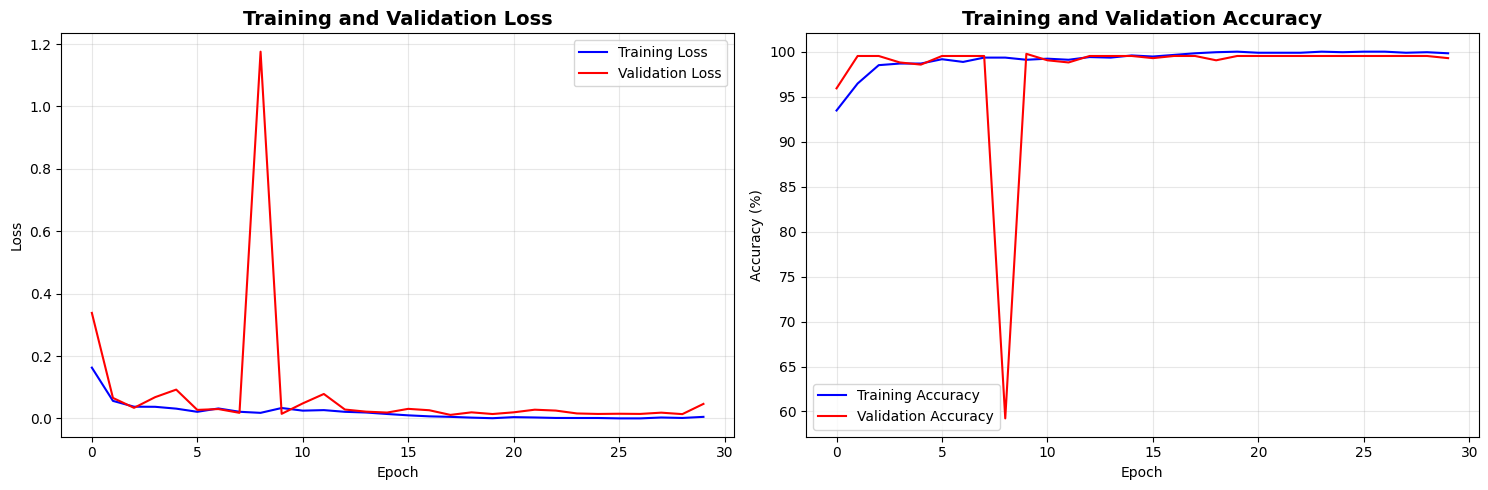


 Final Training Statistics:
  Best validation accuracy: 99.76%
  Final training accuracy: 99.82%
  Final validation accuracy: 99.28%
  Final training loss: 0.0051
  Final validation loss: 0.0466


In [14]:
# Plot training history
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)

# Print final training statistics
print(f"\n Final Training Statistics:")
print(f"  Best validation accuracy: {max(val_accuracies):.2f}%")
print(f"  Final training accuracy: {train_accuracies[-1]:.2f}%")
print(f"  Final validation accuracy: {val_accuracies[-1]:.2f}%")
print(f"  Final training loss: {train_losses[-1]:.4f}")
print(f"  Final validation loss: {val_losses[-1]:.4f}")

## 14. Evaluate on Validation Set

Evaluating Evaluating model on validation set...

Training Validation Set Results:
Validation Accuracy: 0.9928 (99.28%)

Validation Classification Report:
              precision    recall  f1-score   support

   Non-COVID       1.00      1.00      1.00       400
    COVID-19       0.94      0.88      0.91        17

    accuracy                           0.99       417
   macro avg       0.97      0.94      0.95       417
weighted avg       0.99      0.99      0.99       417



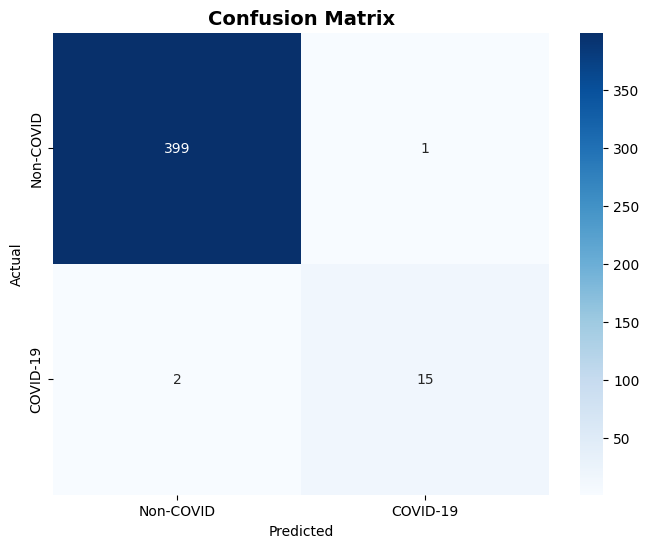

In [15]:
print("Evaluating Evaluating model on validation set...")
val_accuracy, val_report, val_conf_matrix, val_predictions, val_labels = evaluate_model(model, val_loader, device)

print(f"\nTraining Validation Set Results:")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print("\nValidation Classification Report:")
print(val_report)

# Plot validation confusion matrix
plot_confusion_matrix(val_conf_matrix)

## 15. Final Test Set Evaluation (Unseen Data) Testing

In [16]:
print("\n" + "="*60)
print("Testing FINAL TEST SET EVALUATION (UNSEEN DATA)")
print("="*60)

test_accuracy, test_report, test_conf_matrix, test_predictions, test_labels = evaluate_model(model, test_loader, device)

# Calculate additional metrics
covid_correct = sum(1 for i in range(len(test_labels)) if test_labels[i] == 1 and test_predictions[i] == 1)
covid_total = sum(1 for label in test_labels if label == 1)
non_covid_correct = sum(1 for i in range(len(test_labels)) if test_labels[i] == 0 and test_predictions[i] == 0)
non_covid_total = sum(1 for label in test_labels if label == 0)

print(f"\nDataset TEST SET RESULTS (3,100 images - 100 COVID + 3,000 Non-COVID):")
print(f"Overall Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"\nEvaluating COVID-19 Detection (100 images):")
print(f"  Correctly identified: {covid_correct}/{covid_total}")
if covid_total > 0:
    print(f"  COVID-19 Accuracy: {covid_correct/covid_total:.4f} ({covid_correct/covid_total*100:.2f}%)")
else:
    print(f"  COVID-19 Accuracy: N/A (no COVID samples)")
print(f"\nEvaluating Non-COVID Detection (3,000 images):")
print(f"  Correctly identified: {non_covid_correct}/{non_covid_total}")
if non_covid_total > 0:
    print(f"  Non-COVID Accuracy: {non_covid_correct/non_covid_total:.4f} ({non_covid_correct/non_covid_total*100:.2f}%)")
else:
    print(f"  Non-COVID Accuracy: N/A (no Non-COVID samples)")

print(f"\nTraining Detailed Classification Report:")
print(test_report)


Testing FINAL TEST SET EVALUATION (UNSEEN DATA)

Dataset TEST SET RESULTS (3,100 images - 100 COVID + 3,000 Non-COVID):
Overall Accuracy: 0.9952 (99.52%)

Evaluating COVID-19 Detection (100 images):
  Correctly identified: 89/100
  COVID-19 Accuracy: 0.8900 (89.00%)

Evaluating Non-COVID Detection (3,000 images):
  Correctly identified: 2996/3000
  Non-COVID Accuracy: 0.9987 (99.87%)

Training Detailed Classification Report:
              precision    recall  f1-score   support

   Non-COVID       1.00      1.00      1.00      3000
    COVID-19       0.96      0.89      0.92       100

    accuracy                           1.00      3100
   macro avg       0.98      0.94      0.96      3100
weighted avg       1.00      1.00      1.00      3100



## 16. Test Set Confusion Matrix


Dataset Test Set Confusion Matrix Visualization:


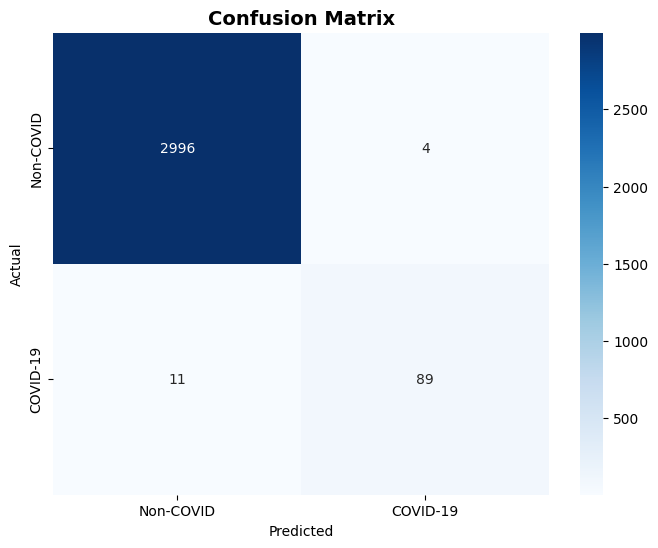

In [17]:
# Plot test confusion matrix
print(f"\nDataset Test Set Confusion Matrix Visualization:")
plot_confusion_matrix(test_conf_matrix)